In [1]:
## Import reqired libraries
###########################

# General Librarys
import os
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Scikit-learn library models, metric, etc
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Boosting methods (XGBosst, lightGBM)
import lightgbm as lgbm
import xgboost as xgb

# import joblib to save and load prediction models
import joblib

#suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# EDA

In [2]:
#Load train and test dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head(5)

,property,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,5467900070,20140502,342000.0,3,2.00,1930,11947,1.0,0,0,...,8,1930,0,1966,0,98042,47.3672,-122.151,2200,12825
1,7197300105,20140502,550000.0,4,2.50,1940,10500,1.0,0,0,...,7,1140,800,1976,0,98052,47.6830,-122.114,2200,10500
2,7525100520,20140502,335000.0,2,2.00,1350,2560,1.0,0,0,...,8,1350,0,1976,0,98052,47.6344,-122.107,1790,2560
3,2591720070,20140502,482000.0,4,2.50,2710,35868,2.0,0,0,...,9,2710,0,1989,0,98038,47.3750,-122.022,2780,36224
4,7739100015,20140502,463000.0,3,1.75,1710,7320,1.0,0,0,...,7,1710,0,1948,0,98155,47.7512,-122.281,2260,8839


In [3]:
# Create new columns for year and month in training data
df_train['date'] = pd.to_datetime(df_train['date'].astype(str), format='%Y%m%d')
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month

# Create new columns for year and month in test data
df_test['date'] = pd.to_datetime(df_test['date'].astype(str), format='%Y%m%d')
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month

# Delete the old date columns in train and test data
df_train = df_train.drop(['date'], axis = 1)
df_test = df_test.drop(['date'], axis = 1)

df_train.head()


,property,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,5467900070,342000.0,3,2.00,1930,11947,1.0,0,0,4,...,0,1966,0,98042,47.3672,-122.151,2200,12825,2014,5
1,7197300105,550000.0,4,2.50,1940,10500,1.0,0,0,4,...,800,1976,0,98052,47.6830,-122.114,2200,10500,2014,5
2,7525100520,335000.0,2,2.00,1350,2560,1.0,0,0,3,...,0,1976,0,98052,47.6344,-122.107,1790,2560,2014,5
3,2591720070,482000.0,4,2.50,2710,35868,2.0,0,0,3,...,0,1989,0,98038,47.3750,-122.022,2780,36224,2014,5
4,7739100015,463000.0,3,1.75,1710,7320,1.0,0,0,3,...,0,1948,0,98155,47.7512,-122.281,2260,8839,2014,5


<AxesSubplot:>

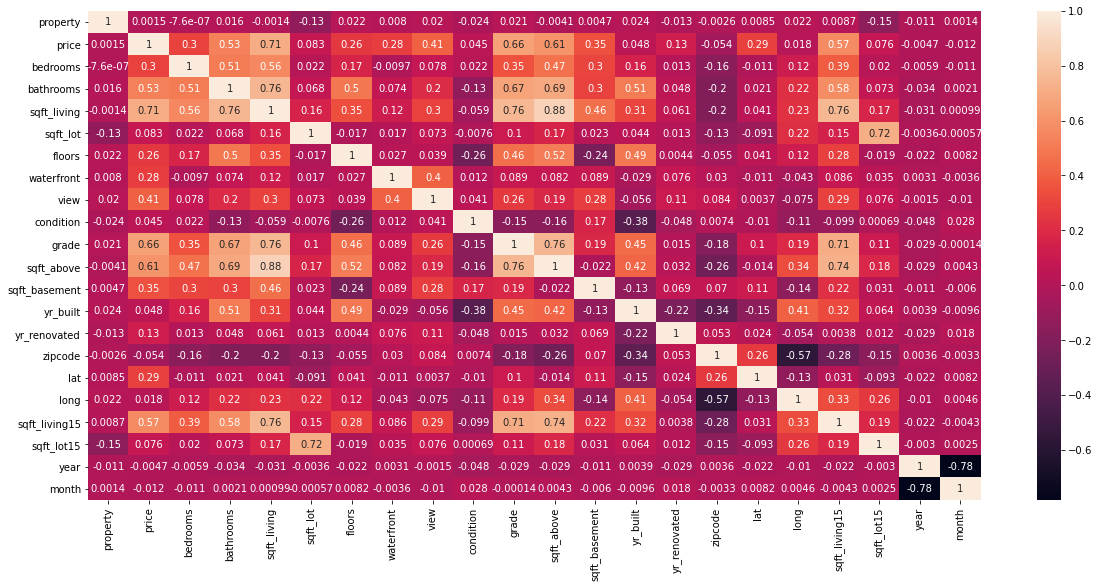

In [4]:
# Generate coralation plot (heatmap) and save it
corr = df_train.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr, annot=True)

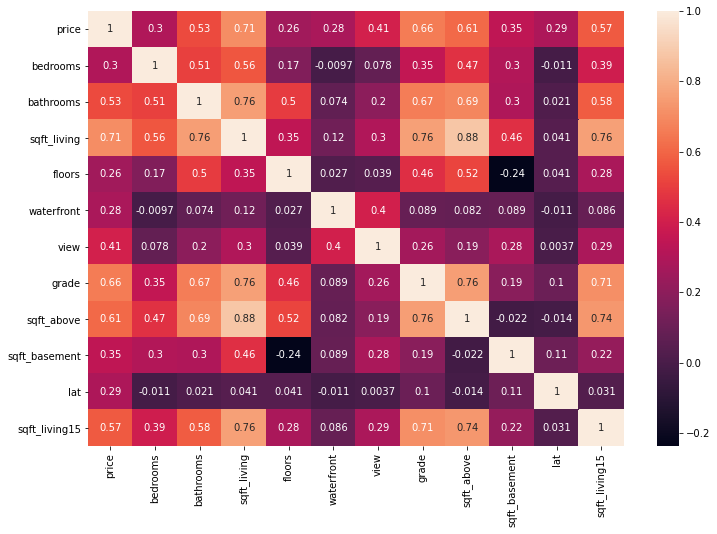

In [5]:
# Generate heatmap with abs(corr) values grater than 0.2 and save it
top_feature = corr.index[abs(corr['price'])>0.2]

plt.subplots(figsize=(12, 8))
top_corr = df_train[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

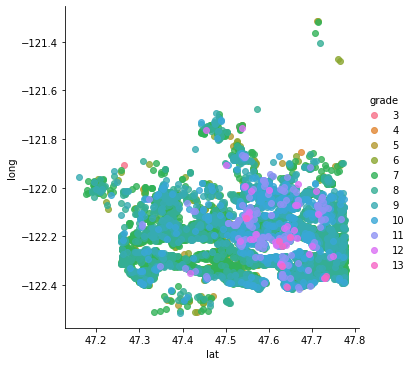

In [6]:
# Plot houses' geographic coordinates based on their grade
sns.lmplot('lat', 'long', data=df_train, hue='grade', fit_reg=False)

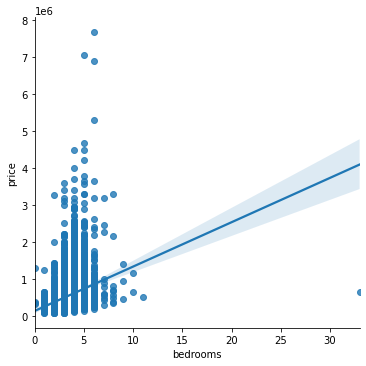

In [7]:
# Scatter plot, price against number of bedroom 
# 1. helps to find the the relationship between pricec and number of bedrooms
# 2. helps to identify outliers
sns.lmplot(x='bedrooms',y='price',data=df_train)

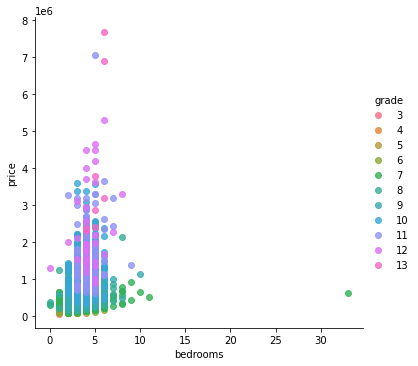

In [8]:
# Scatter plot, price against number of bedroom colored with grades
sns.lmplot(x='bedrooms',y='price',data=df_train,hue='grade',fit_reg=False)

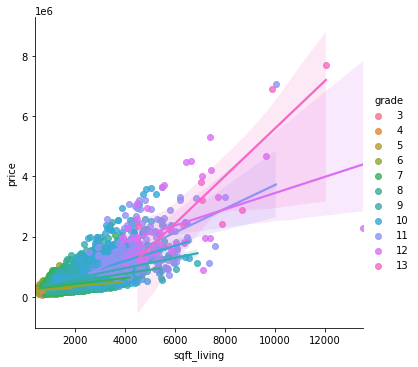

In [9]:
# Scatter plot, price against sqft_living colored with grades

sns.lmplot(x='sqft_living',y='price',data=df_train,hue='grade')

# Feature Engineering

In [10]:
def preprocessing(data_location):
    ''' Load train and test data, then:
    1. Drop "property" column since it is a unique identifier
    2. Add new columns for year and month 
    3. Delete date column from dataset
    4. Create new features for dataset by calculating distance of each house from downtown
    
    Parameters:
        data_location(str): data location in local machine
        down_lat(float): down town latitude value
        down_long(float): down town langitude value
    Returns:
        df(pandas dataframe): preprocessed pandas dataframe
    '''
    
    # Load the data
    df = pd.read_csv(data_location)

    # Delete property
    df = df.drop(['property'], axis = 1)

    # Add month and year as new columns and delete the date column
    df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Delete the old date column
    df = df.drop(['date'], axis = 1)

    
    return df

In [11]:
# Log transform following columns to meake them less skewd and closer to normal distribution
def log_transform(df, trans_columns):
    ''' Apply log transform to meake columns less skewd and closer to normal distribution
    
    Parameters:
        df(pandas dataframe): raw dataframe 
        trans_columns(array): list of columns needs log transform      
    
    Returns:
        df_updated(pandas dataframe): Updated dataframe with tranformed columns columns
    '''
    
    for column in trans_columns:
        df[column] = np.log(1 + df[column])
    df_updated = df
    
    return df_updated

In [12]:
def feature_generator(df, down_lat, down_long):
    ''' Generate new features
    
    Parameters:
        df(pandas dataframe): raw dataframe 
        down_lat(float): downtown latitude, used to generate a new feature        
        down_long(float): downtown longitude, used to generate a new feature 
    
    Returns:
        df_updated(pandas dataframe): Updated dataframe with new columns
    '''
    
    # Create new columns representing distance of each house from downtown
    df['lat_to_downtown']=(df['lat']-down_lat).abs()
    df['long_to_downtown']=(df['long']-(down_long)).abs()
    
    # Create new column representing mean sqft of lot for each house in each (zipcode,grade) group
    df['mean_sqft_lot'] = df.groupby(by=['zipcode','grade'])['sqft_lot'].transform('mean')
    
    # Create new column representing mean sqft of living areain 2015 for each house in each (zipcode,grade) group
    df['mean_sqft_living15'] = df.groupby(by=['zipcode','grade'])['sqft_living15'].transform('mean')
    
    # Create new column representing mean sqft of lot area in 2015 for each house in each (zipcode,grade) group
    df['mean_sqft_lot15'] = df.groupby(by=['zipcode','grade'])['sqft_lot15'].transform('mean')
    
    # Create new column representing mean sqft of above area for each house in each (zipcode,grade) group
    df['mean_sqft_sqft_above'] = df.groupby(by=['zipcode','grade'])['sqft_above'].transform('mean')
    
    # Create new column representing mean grade for each house in each zipcode group
    df['mean_grade'] = df.groupby(by=['zipcode'])['grade'].transform('mean')
    
    df_updated = df

    return df_updated

In [13]:
# Preprocess train and test datasets
df_train = preprocessing('train.csv')

# Use log transform to make the columns less skewed (to meet the assumptions of inferential statistics)
trans_columns = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']
df_train = log_transform(df_train, trans_columns + ['price'])

# Preprocess train and test datasets
df_train = feature_generator(df_train, 47.36217, -122.20069)

# Additional step in preprocessing train data 
# Delete outliers in number of bedrooms from train data
df_train=df_train[df_train['bedrooms']<11]

In [14]:
df_train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,year,month,lat_to_downtown,long_to_downtown,mean_sqft_lot,mean_sqft_living15,mean_sqft_lot15,mean_sqft_sqft_above,mean_grade
0,12.742569,3,2.00,7.565793,9.388319,1.0,0,0,4,8,...,9.459230,2014,5,0.00503,0.04969,9.330559,7.722529,9.248797,2227.625000,7.416327
1,13.217675,4,2.50,7.570959,9.259226,1.0,0,0,4,7,...,9.259226,2014,5,0.32083,0.08669,9.015195,7.422511,8.967209,1337.870968,8.186047
2,12.721889,2,2.00,7.208600,7.848153,1.0,0,0,3,8,...,7.848153,2014,5,0.27223,0.09369,9.012671,7.683152,9.011286,1924.732143,8.186047
3,13.085701,4,2.50,7.905073,10.487629,2.0,0,0,3,9,...,10.497505,2014,5,0.01283,0.17869,9.409189,7.921605,9.310460,2885.390244,7.600733
4,13.045484,3,1.75,7.444833,8.898502,1.0,0,0,3,7,...,9.087042,2014,5,0.38903,0.08031,9.076119,7.374384,9.088679,1394.181818,7.250000


In [15]:
# Split train dataset to train data (90% of data) and validation data (10 % of data)
X_train,X_valid,y_train,y_valid=train_test_split(df_train.drop('price',axis=1),df_train['price'],test_size=0.1, random_state=3)

In [16]:
# R2 adjusted function used to evaluate performance of LightGBM and Xgboost models
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

# LightGBM

In [17]:
def run_lgbm(X_train, y_train, X_valid, y_valid):
    ''' Train LightGBM model and save it
    
    Parameters:
        X_train(pandas dataframe): Training data
        y_train(array): Response variable of training data         
        X_valid(pandas dataframe): Validation data
        y_valid(array): Response variable of validation data 
    
    Returns:
        None
    '''
    
    # Create train and validation datasets for LightGBM classifier
    lgbm_train = lgbm.Dataset(X_train, y_train)
    lgbm_eval = lgbm.Dataset(X_valid, y_valid, reference=lgbm_train)

    # Create grid parameters for tuning LightGBM
    gridParams = {
        "max_depth": [-1],
        'learning_rate': [0.04,0.045,0.05,0.055],
        'n_estimators': [200,500],
        'num_leaves': [20,25,50],
        'boosting_type' : ['gbdt'],
        'feature_fraction': [0.7,0.9],
        'bagging_fraction' :[0.9],
        'bagging_freq' :[10]  
        }

    # Define the fixed parameters dictionary
    params = {'random_state' : 10,
              'objective': 'regression',
              'min_data_in_leaf': 20,      
              'metric': [12,'rmse']
             }

    # Create regressor 
    clf = lgbm.LGBMRegressor(**params)

    # Create the grid
    grid = GridSearchCV(clf, gridParams,
                        verbose=2,
                        cv=5,
                        n_jobs=2,
                        return_train_score = True)
    # Run the grid
    grid.fit(X_train, y_train)

    # Select the best values obtained in tuning part
    params['learning_rate'] = grid.best_params_['learning_rate']
    params['num_leaves'] = grid.best_params_['num_leaves']
    params['learning_rate'] = grid.best_params_['learning_rate']
    params['max_depth']= grid.best_params_['max_depth']
    params['learning_rate']= grid.best_params_['learning_rate']
    params['num_leaves']= grid.best_params_['num_leaves']
    params['boosting_type']= grid.best_params_['boosting_type']
    params['bagging_fraction']= grid.best_params_['bagging_fraction']
    params['bagging_freq']= grid.best_params_['bagging_freq']
    params['feature_fraction']= grid.best_params_['feature_fraction']

    # Train with tuned parameters
    evaluation_results = {}
    clf_tuned = lgbm.train(params,
                     lgbm_train,
                     valid_sets=[lgbm_train,lgbm_eval], 
                     valid_names=['Train', 'Test'],
                     categorical_feature=[13],
                     evals_result=evaluation_results,
                     num_boost_round=1500,
                     early_stopping_rounds=300,
                     verbose_eval=20
                    )

    # Save the best model 
    clf_tuned.save_model('lgbm_model.txt', num_iteration=clf_tuned.best_iteration) 
    
    # Load the saved LightGBM model
    lgbm_model = lgbm.Booster(model_file='lgbm_model.txt')
    
    # Predict response varibale valid data by Xgboost
    lgbm_preds=lgbm_model.predict(X_valid)
    
    # Print performance of LightGBM on validation data (MAE, RMSE, R2, and R2_Adjusted values)    
    print('Mean absolute error = \t {}'.format(np.round(mean_absolute_error(y_valid, lgbm_preds), 2 )))
    print('RMSE = \t {}'.format(np.round(np.sqrt(mean_squared_error(y_valid, lgbm_preds)),5 )))
    print('R2 = \t {}'.format(np.round(r2_score(y_valid, lgbm_preds), 3 )))
    print('R2_adjusted = \t {}'.format(np.round(adjustedR2(r2_score(y_valid, lgbm_preds),X_valid.shape[0],X_valid.shape[1]), 3)))
    
    return lgbm_preds

In [18]:
run_lgbm(X_train, y_train, X_valid, y_valid)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   24.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:  2.7min finished


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3874
[LightGBM] [Info] Number of data points in the train set: 8998, number of used features: 27
[LightGBM] [Info] Start training from score 13.040517
Training until validation scores don't improve for 300 rounds
[20]	Train's rmse: 0.261429	Test's rmse: 0.25762
[40]	Train's rmse: 0.186433	Test's rmse: 0.195177
[60]	Train's rmse: 0.

array([12.93581308, 12.72205178, 12.84894133, 12.5987445 , 12.68866064,
       12.40534037, 12.79767579, 13.29816286, 13.01541484, 12.48444612,
       13.41437512, 13.50527538, 12.93778848, 13.82372653, 12.62437622,
       13.14061627, 12.54938677, 12.16130177, 13.24210068, 12.45052324,
       12.70918536, 12.35243457, 12.62131345, 13.71178803, 12.33654145,
       13.62619136, 12.93253257, 13.52320211, 12.43165839, 12.99770997,
       12.46835885, 13.18160514, 13.5321925 , 13.59942446, 12.48271256,
       12.74418688, 12.94336357, 13.44344616, 12.99260985, 12.76324532,
       12.57752756, 13.19424284, 13.27595403, 13.33053934, 12.67771148,
       12.95154082, 12.90893721, 13.02682507, 12.80720231, 13.06719343,
       13.30915701, 13.36640876, 13.32202168, 13.17306258, 12.81649817,
       12.59790468, 13.45476633, 12.49990991, 12.606328  , 12.83163043,
       13.28875396, 12.66212491, 12.27839487, 13.3382782 , 13.8044721 ,
       13.00152733, 13.10901926, 12.96170696, 12.81984994, 12.89

# XGboost

In [19]:
def run_xgb(X_train, y_train, X_valid, y_valid):
    ''' Train Xgboost model and save it
    
    Parameters:
        X_train(pandas dataframe): Training data
        y_train(array): Response variable of training data         
        X_valid(pandas dataframe): Validation data
        y_valid(array): Response variable of validation data 
    
    Returns:
        None
    '''

    # Create grid parameters for Xgboost
    param_grid = {
        "xgbrg__n_estimators": [500],
        "xgbrg__learning_rate": [0.17,0.15],
        'max_depth': [3,4,5],
        'subsample': [0.75,0.8,0.85]
    }

    # Define the fixed parameters dictionary
    fit_params = {"xgbrg__eval_set": [(X_valid, y_valid)], 
                  "xgbrg__early_stopping_rounds": 50, 
                  "xgbrg__verbose": False,
                  "tree_method ": "hist",
                  "grow_policy" : "lossguide"} 

    # Create the grid and run it
    xgbr = xgb.XGBRegressor(**fit_params)
    searchCV = GridSearchCV(xgbr, cv=10, param_grid=param_grid,verbose=2, n_jobs=2,scoring= 'neg_mean_squared_error')
    searchCV.fit(X_train, y_train) 

    # Training Xgboost with the cv winner
    xgb_pars={}
    xgb_pars={**fit_params,**searchCV.best_params_}

    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)

    eval_set = [(dtrain, 'train'),(dvalid, 'eval')]
    num_round=500
    xgb_tuned = xgb.train(xgb_pars, dtrain , num_round, eval_set , early_stopping_rounds=250,verbose_eval=15)

    # Save Xgboost model
    joblib.dump(xgb_tuned,'xgb_model') 
    
    #load saved model
    xgb_tuned = joblib.load('xgb_model')
    best_iteration = xgb_tuned.best_iteration

    # Predict response varibale valid data by Xgboost
    xgb_preds = xgb_tuned.predict(dvalid, ntree_limit = best_iteration)

    # Print performance of LightGBM on validation data (MAE, RMSE, R2, and R2_Adjusted values)
    print('Mean absolute error = \t {}'.format(np.round(mean_absolute_error(y_valid, xgb_preds), 2 )))
    print('RMSE = \t {}'.format(np.round(np.sqrt(mean_squared_error(y_valid, xgb_preds)),5 )))
    print('R2 = \t {}'.format(np.round(r2_score(y_valid, xgb_preds), 3 )))
    print('R2_adjusted = \t {}'.format(np.round(adjustedR2(r2_score(y_valid, xgb_preds),X_valid.shape[0],X_valid.shape[1]), 3)))

In [20]:
run_xgb(X_train, y_train, X_valid, y_valid)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   20.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:  1.9min finished


[23:06:47] WARNING: ..\src\learner.cc:541: 
Parameters: { tree_method , xgbrg__early_stopping_rounds, xgbrg__eval_set, xgbrg__learning_rate, xgbrg__n_estimators, xgbrg__verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:06:48] WARNING: ..\src\learner.cc:541: 
Parameters: { tree_method , xgbrg__early_stopping_rounds, xgbrg__eval_set, xgbrg__learning_rate, xgbrg__n_estimators, xgbrg__verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:8.79101	eval-rmse:8.79928
[15]	train-rmse:0.18741	eval-rmse:0.19527
[30]	train-rmse:0.16073	eval-rmse:0.18037

## Predict Test Data

In [21]:
def lgbm_test_predictor(model_name, data):
    ''' Load LightGBM saved model and predict test data
    
    Parameters:
        model_name(str): LightGBM saved model's name
        data(pandas dataframe): Test data 
    
    Returns:
        LightGBM_test_preds(array): Predicted values for test data
    '''
    
    # Load LightGBM model
    lgbm_model = lgbm.Booster(model_file='lgbm_model.txt')
    
    # Drop identifier column from test data 
    df_test_lgbm = df_test.drop('id',axis=1)
    
    # Predict test dataset by tuned LightGBM and save the data to be passed to ensemble model
    lgbm_test_preds = lgbm_model.predict(df_test_lgbm)

    return lgbm_test_preds

In [22]:
def xgb_test_predictor(model_name, data):
    ''' Load Xgboost saved model and predict test data
    
    Parameters:
        model_name(str): Xgboost saved model's name
        data(pandas dataframe): Test data 
    
    Returns:
        XGB_test_preds(array): Predicted values for test data
    '''

    # Load Xgboost model 
    xgb_model = joblib.load('xgb_model')
    
    # Drop identifier column from test data
    df_test_xgb =df_test.drop('id',axis=1)
    df_test_xgb_DM=xgb.DMatrix(df_test_xgb)
    
    # Predict test dataset by tuned Xgboost and save the data to be passed to ensemble model
    xgb_test_preds = xgb_model.predict(df_test_xgb_DM)

    return xgb_test_preds

In [23]:
# Preprocess train and test datasets
df_test = preprocessing('test.csv')

# Use log transform to make the columns less skewed (to meet the assumptions of inferential statistics)
trans_columns = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']
df_test = log_transform(df_test, trans_columns)

# Preprocess test datasets
df_test = feature_generator(df_test, 47.36217, -122.20069)

In [24]:
# Predict test data by LightGBM and Xgboost models
lgbm_test_preds = lgbm_test_predictor('lgbm_model.txt', df_test)
xgb_test_preds = xgb_test_predictor('xgb_model', df_test)